In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat

## Part II : Hydraulic Model

In this part, we have access to a physical model of the maximum river height each year, given through the formula :
$$
H = \left( \frac{Q}{K_s \sqrt{\frac{Z_m - Z_v}{L}} B} \right)^{3/5}
$$
With $Q$ the river flow, $K_s$ a hydraulic coefficient, $B$ the river width and $Z_m$ and $Z_v$ the soil level upstream and downstream.  
We want to minimize $\mathbb{P}(S>0)$ where $S=Z_v+H-h_d-Z_b$ where $h_d$ is the height of the dike, and $Z_b$ the height of the bank.

We have given laws for the random parameters. We need to generate an empirical cdf for the variable $Z_v+H-Z_b$ so that we can choose $h_d$ for the minimization criteria.  

In this first approach of the physical model, all the laws are considered independant and thus can be randomly generated separetely for a valid dataset.

### 1 : Generating the random vectors for random variables, setting up constants

In [2]:
# Constants
L = 5000    # Length of section (m)
B = 300     # Watercourse width (m)
Zb = 55.5  # Shoreline elevation (m NGF)

# Simulation parameters 
vec_size = 100000                # Points to generate

mode_Q, scale_Q = 1013, 558 # Q law (Gumbel)
exp_K, std_K = 30, 7.5      # Ks law (Gaussian)
exp_Zv, hr_Zv = 50, 1       # Zv law (Triangular)
exp_Zm, hr_Zm = 55, 1       # Zm law (Triangular)

def get_observation(vec_size):
    # Generate random variables vectors of size vec_size
    Q_vec = stat.gumbel_r.rvs(loc=mode_Q, scale=scale_Q, size=vec_size)
    Ks_vec = stat.norm.rvs(loc=exp_K, scale=std_K, size=vec_size)
    Zv_vec = stat.triang.rvs(c=1/2, loc=exp_Zv-hr_Zv, scale=2*hr_Zv, size=vec_size)
    Zm_vec = stat.triang.rvs(c=1/2, loc=exp_Zm-hr_Zm, scale=2*hr_Zm, size=vec_size)
    return Q_vec, Ks_vec, Zv_vec, Zm_vec

Plot the resulting vectors as empirical distribution

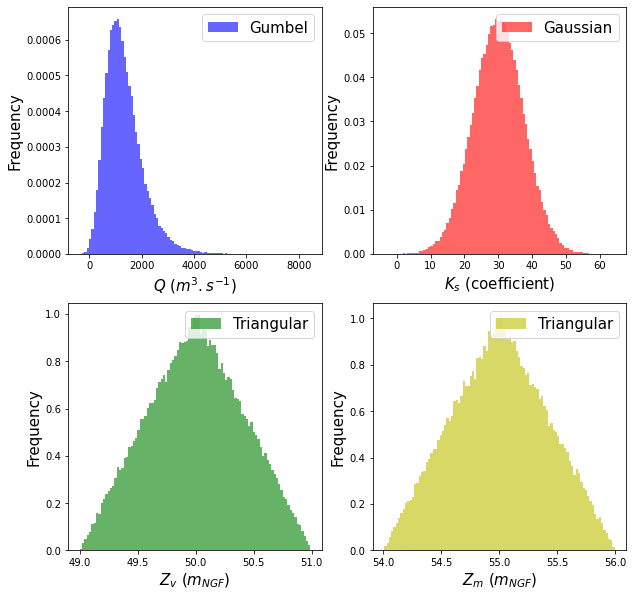

In [3]:
binsize = 100

Q_vec, Ks_vec, Zv_vec, Zm_vec = get_observation(vec_size)

fig, ax = plt.subplots(2,2,figsize=(10,10),sharex=False)
ax[0,0].hist(Q_vec, bins = binsize, facecolor='b', alpha=0.6, density=True, label = 'Gumbel')
ax[0,0].set_xlabel(r'$Q$ ($m^3.s^{-1}$)',fontsize=15)
ax[0,0].set_ylabel('Frequency',fontsize=15)
ax[0,0].legend(fontsize=15)

ax[0,1].hist(Ks_vec, bins = binsize, facecolor='r', alpha=0.6, density=True, label = 'Gaussian')
ax[0,1].set_xlabel(r'$K_s$ (coefficient)',fontsize=15)
ax[0,1].set_ylabel('Frequency',fontsize=15)
ax[0,1].legend(fontsize=15)

ax[1,0].hist(Zv_vec, bins = binsize, facecolor='g', alpha=0.6, density=True, label = 'Triangular')
ax[1,0].set_xlabel(r'$Z_v$ ($m_{NGF}$)',fontsize=15)
ax[1,0].set_ylabel('Frequency',fontsize=15)
ax[1,0].legend(fontsize=15)

ax[1,1].hist(Zm_vec, bins = binsize, facecolor='y', alpha=0.6, density=True, label = 'Triangular')
ax[1,1].set_xlabel(r'$Z_m$ ($m_{NGF}$)',fontsize=15)
ax[1,1].set_ylabel('Frequency',fontsize=15)
ax[1,1].legend(fontsize=15)
plt.show()

### 2 : Process data to retain physical values

We notice that the distribution of $Q$ and $K_s$ have an infinite support. This is valid for high values of these variables, but null or negative values do not make physical sense. 

A negative flowrate or negative has to be removed from the generated vectors, as well as low values of $K_s$, that usually do not go below $5$.

In [4]:
def clean_data(Q_vec, Ks_vec, Zv_vec, Zm_vec):
    """
    Takes the simulation data and removes non physical data
    """
    to_remove_ind = [] # List of indexes that violate positivity criteria
    for i in range(len(Q_vec)):
        if Q_vec[i]<=0:
            to_remove_ind.append(i)
        if Ks_vec[i]<=5:
            to_remove_ind.append(i)
    to_remove_ind = np.array(to_remove_ind)

    # Removing these indices from the dataset
    Q_vec = np.delete(Q_vec, to_remove_ind)
    Ks_vec = np.delete(Ks_vec, to_remove_ind)
    Zv_vec = np.delete(Zv_vec, to_remove_ind)
    Zm_vec = np.delete(Zm_vec, to_remove_ind)
    return Q_vec, Ks_vec, Zv_vec, Zm_vec

### 3 : Generate the empirical distribution for $H$ and $S|_{h_d=0}$

Now that we have cleared our dataset, we can obtain and study the flood height and overflow height.  
We first plot the corresponding density functions, then we plot the cdf for the variable of interest $S$ whose quantiles can be used to calculate dike height at various risk levels.

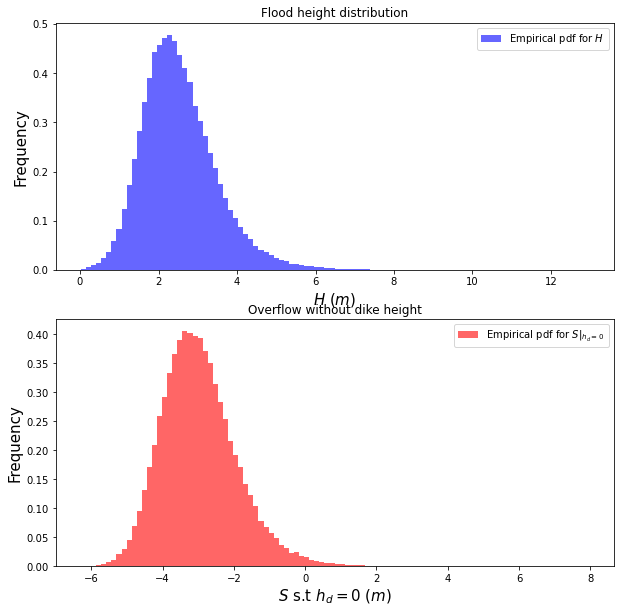

In [5]:
def simulation(B, Zb):
    """
    Simulates one obesrvation of the empirical pdf of H the water level and S the overflow if dike height is null
    """
    Q_vec, Ks_vec, Zv_vec, Zm_vec = get_observation(vec_size)
    Q_vec, Ks_vec, Zv_vec, Zm_vec = clean_data(Q_vec, Ks_vec, Zv_vec, Zm_vec)

    H_vec = (Q_vec/(Ks_vec*B*np.sqrt((Zm_vec-Zv_vec)/L)))**(3/5)
    S = Zv_vec + H_vec - Zb

    return H_vec, S

H_vec, S = simulation(B, Zb)
max_H = max(S)
q95 = np.quantile(S, 0.95)
q99 = np.quantile(S, 0.99)

# Visualization of results
fig, ax = plt.subplots(2,1,figsize=(10,10),sharex=False)
ax[0].hist(H_vec, bins = binsize, facecolor='b', density=True, alpha=0.6, label=r"Empirical pdf for $H$")
ax[0].set_title('Flood height distribution')
ax[0].set_xlabel(r'$H$ ($m$)',fontsize=15)
ax[0].set_ylabel('Frequency',fontsize=15)
ax[0].legend()

ax[1].hist(S, bins = binsize, facecolor='r', density=True, alpha=0.6, label=r"Empirical pdf for $S|_{h_d=0}$")
ax[1].set_title('Overflow without dike height')
ax[1].set_xlabel(r'$S$ s.t $h_d=0$ ($m$)',fontsize=15)
ax[1].set_ylabel('Frequency',fontsize=15)
ax[1].legend()
plt.show()


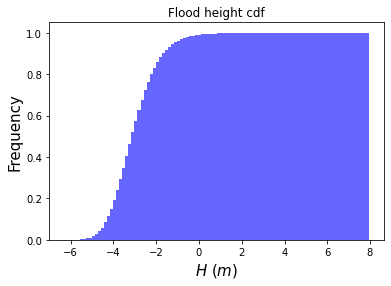

Maximum height :  7.941079955447435
95th quantile :  -1.0915662177549474
99th quantile :  0.08574989729379792


In [6]:
plt.figure()
plt.hist(S, bins = binsize, facecolor='b', density=True, cumulative=True, alpha=0.6)
plt.title('Flood height cdf')
plt.xlabel(r'$H$ ($m$)',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.show()

print("Maximum height : ",max_H)
print("95th quantile : ",q95)
print("99th quantile : ",q99)

### 4 : Confidence interval for $h_d$

To add robustness to our simulations, we generate multiple times the scenario to get multiple values for $h_d$ to have a confidence interval.

In [7]:
# We do N_iter simulations and keep the quantile of interest
N_iter = 1000
dike_heights = np.zeros(N_iter)

for i in range(N_iter):
    H_vec, S = simulation(B, Zb)
    q999 = np.quantile(S, 0.999)

    dike_heights[i] = q999

Confidence Interval for h_d at 95% confidence level :
[1.80, 2.16]
Mean value : 1.98


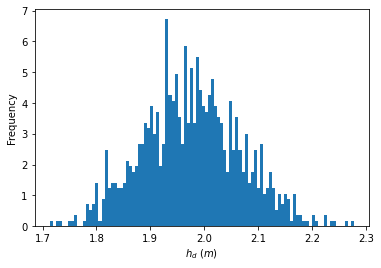

In [8]:
print("Confidence Interval for h_d at 95% confidence level :")
print("[{a:.2f}, {b:.2f}]".format(a=np.quantile(dike_heights, 0.025), b=np.quantile(dike_heights, 0.975)))
print("Mean value : {a:.2f}".format(a=np.mean(dike_heights)))

plt.figure()
plt.hist(dike_heights, binsize, density=True)
plt.xlabel(r"$h_d$ ($m$)")
plt.ylabel("Frequency")
plt.show()

## Additional part : with correlated values

We are given in following approximation correlation coefficient between the different random variables $K_s$, $Z_v$ and $Z_m$ for 2 scenarios.

To generate correlated random variables, we need the marginal laws as well as the covariance matrix.  
The covariance is given with the correlation coefficient as $Cov(X,Y) = r * \sigma_X \sigma_Y$  

With the covariance matrix $\Sigma$, we generate $N$ observations for a gaussian vector with individual centered and unit variance normal laws $Z$ s.t $Z \rightsquigarrow \mathcal{N}(0,\Sigma)$

Applying the cdf of the gaussian law to each component, we obtain a uniform distribution in $[0,1]$ for each variable, keeping the covariance untouched. Finally, we apply the inverse cdf of each individual law (here triangular) to obtain our correlated vectors of observations.

In [26]:
# A scenario consists of the 3 correlation coefficients
# In order : r_Ks_Zv, r_Zv_Zm, r_Ks_Zm

scenario1 = [-0.6, 0.6, 0]
scenario2 = [-0.3, 0.66, -0.5]

In [27]:
def cov_mat(r_X_Y):
    """
    r_X_Y (list) : Correlation coefficients of laws considered

    Generates a covariance matrix for a gaussian vector of dimension 3 given the correlation coefficients.
    Here Cov = r as they are unit variance
    We generate it so that the variables will become (Ks, Zv, Zm)
    """
    r_Ks_Zv = r_X_Y[0]
    r_Zv_Zm = r_X_Y[1]
    r_Ks_Zm = r_X_Y[2]
    
    cov = np.array([
        [1., r_Ks_Zv, r_Ks_Zm],
        [r_Ks_Zv, 1., r_Zv_Zm],
        [r_Ks_Zm, r_Zv_Zm, 1.]
    ])
    return cov

def generate_gaussian_vector(sigma, size):
    """
    sigma (array) : Covariance matrix of the 3 laws
    size (int) : Amount of observations to generate

    Generates the three random variables with a gaussian vector of covariance sigma
    """
    return np.transpose(stat.multivariate_normal.rvs(mean=np.zeros(3), cov=sigma, size=size))


In [28]:
def get_Ks(Ks_centered, exp_K, std_K):
    """
    Ks_centered (array) : Generated centered and unit variance observations
    exp_K (float) : Expectation of Ks
    std_K (float) : Standard deviation of Ks

    Returns the Ks vector after decentering and modifying variance
    """
    return Ks_centered*std_K + exp_K

def get_Z(Z_norm, exp_Z, hr_Z):
    """
    Z_norm (array) : Generated centered and unit variance observations
    exp_Z (float) : Expectation of Z
    hr_Z (float) : Half range of Z

    Returns the Z_m/v vector after applying the normal law cdf and inverse cdf of triangular law with according scale and location
    """
    uniform_distrib = stat.norm.cdf(Z_norm)
    Z_triang = stat.triang.ppf(uniform_distrib, c=1/2, loc=exp_Z-hr_Z, scale=2*hr_Z)
    return Z_triang

### Representing the variables in a graph to check correlation

Hereafter we check that our functions are working properly in generating correlated random variables with a sample of 500 observations made

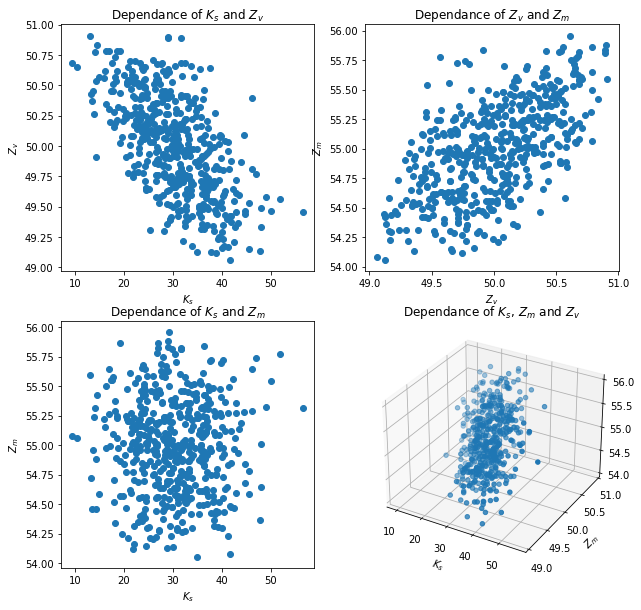

In [29]:
sigma = cov_mat(scenario1)
observations = generate_gaussian_vector(sigma, 500)

Ks1_vec = get_Ks(observations[0], exp_K, std_K)
Zv1_vec = get_Z(observations[1], exp_Zv, hr_Zv)
Zm1_vec = get_Z(observations[2], exp_Zm, hr_Zm)

fig = plt.figure(figsize=(10., 10.))
ax = fig.add_subplot(2, 2, 1)
ax.scatter(Ks1_vec, Zv1_vec)
ax.set_title(r"Dependance of $K_s$ and $Z_v$")
ax.set_xlabel(r"$K_s$")
ax.set_ylabel(r"$Z_v$")

ax = fig.add_subplot(2, 2, 2)
ax.scatter(Zv1_vec, Zm1_vec)
ax.set_title(r"Dependance of $Z_v$ and $Z_m$")
ax.set_xlabel(r"$Z_v$")
ax.set_ylabel(r"$Z_m$")

ax = fig.add_subplot(2, 2, 3)
ax.scatter(Ks1_vec, Zm1_vec)
ax.set_title(r"Dependance of $K_s$ and $Z_m$")
ax.set_xlabel(r"$K_s$")
ax.set_ylabel(r"$Z_m$")

ax = fig.add_subplot(2, 2, 4, projection="3d")
ax.scatter(Ks1_vec, Zv1_vec, Zm1_vec)
ax.set_title(r"Dependance of $K_s$, $Z_m$ and $Z_v$")
ax.set_xlabel(r"$K_s$")
ax.set_ylabel(r"$Z_v$")
ax.set_ylabel(r"$Z_m$")
plt.show()

### Scenario 1

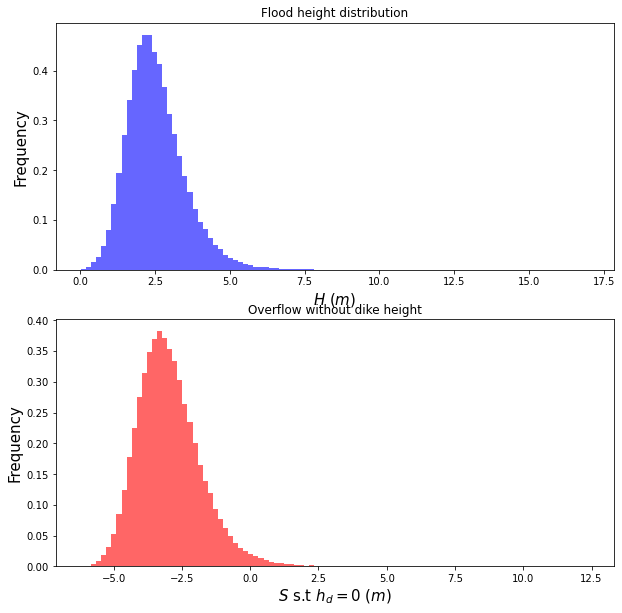

In [30]:
sigma = cov_mat(scenario1)
observations = generate_gaussian_vector(sigma, vec_size)

Ks_vec = get_Ks(observations[0], exp_K, std_K)
Zv_vec = get_Z(observations[1], exp_Zv, hr_Zv)
Zm_vec = get_Z(observations[2], exp_Zm, hr_Zm)
Q_vec = stat.gumbel_r.rvs(loc=mode_Q, scale=scale_Q, size=vec_size)

to_remove_ind = [] # List of indexes that violate positivity criteria
for i in range(len(Q_vec)):
    if Q_vec[i]<=0:
        to_remove_ind.append(i)
    if Ks_vec[i]<=1:
        to_remove_ind.append(i)
to_remove_ind = np.array(to_remove_ind)

# Removing these indices from the dataset
Q_vec = np.delete(Q_vec, to_remove_ind)
Ks_vec = np.delete(Ks_vec, to_remove_ind)
Zv_vec = np.delete(Zv_vec, to_remove_ind)
Zm_vec = np.delete(Zm_vec, to_remove_ind)

H_vec = (Q_vec/(Ks_vec*B*np.sqrt((Zm_vec-Zv_vec)/L)))**(3/5)
S = Zv_vec + H_vec - Zb

max_H = max(S)
q95 = np.quantile(S, 0.95)
q99 = np.quantile(S, 0.99)

fig, ax = plt.subplots(2,1,figsize=(10,10),sharex=False)
ax[0].hist(H_vec, bins = binsize, facecolor='b', density=True, alpha=0.6)
ax[0].set_title('Flood height distribution')
ax[0].set_xlabel(r'$H$ ($m$)',fontsize=15)
ax[0].set_ylabel('Frequency',fontsize=15)

ax[1].hist(S, bins = binsize, facecolor='r', density=True, alpha=0.6)
ax[1].set_title('Overflow without dike height')
ax[1].set_xlabel(r'$S$ s.t $h_d=0$ ($m$)',fontsize=15)
ax[1].set_ylabel('Frequency',fontsize=15)
plt.show()

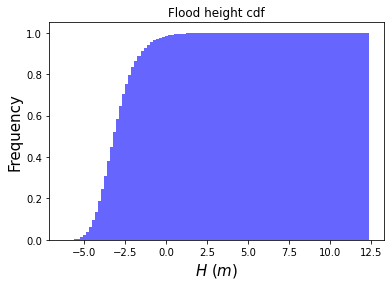

Maximum height :  12.379115673636718
95th quantile :  -0.8892802936509341
99th quantile :  0.4830792222815967


In [31]:
plt.figure()
plt.hist(S, bins = binsize, facecolor='b', density=True, cumulative=True, alpha=0.6)
plt.title('Flood height cdf')
plt.xlabel(r'$H$ ($m$)',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.show()

print("Maximum height : ",max_H)
print("95th quantile : ",q95)
print("99th quantile : ",q99)

### Scenario 2

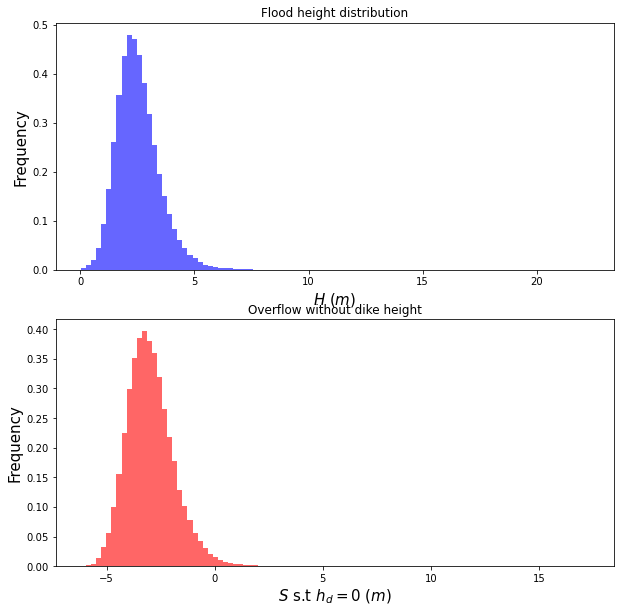

In [32]:
sigma = cov_mat(scenario2)
observations = generate_gaussian_vector(sigma, vec_size)

Ks_vec = get_Ks(observations[0], exp_K, std_K)
Zv_vec = get_Z(observations[1], exp_Zv, hr_Zv)
Zm_vec = get_Z(observations[2], exp_Zm, hr_Zm)
Q_vec = stat.gumbel_r.rvs(loc=mode_Q, scale=scale_Q, size=vec_size)

to_remove_ind = [] # List of indexes that violate positivity criteria
for i in range(len(Q_vec)):
    if Q_vec[i]<=0:
        to_remove_ind.append(i)
    if Ks_vec[i]<=1:
        to_remove_ind.append(i)
to_remove_ind = np.array(to_remove_ind)

# Removing these indices from the dataset
Q_vec = np.delete(Q_vec, to_remove_ind)
Ks_vec = np.delete(Ks_vec, to_remove_ind)
Zv_vec = np.delete(Zv_vec, to_remove_ind)
Zm_vec = np.delete(Zm_vec, to_remove_ind)

H_vec = (Q_vec/(Ks_vec*B*np.sqrt((Zm_vec-Zv_vec)/L)))**(3/5)
S = Zv_vec + H_vec - Zb

max_H = max(S)
q95 = np.quantile(S, 0.95)
q99 = np.quantile(S, 0.99)

fig, ax = plt.subplots(2,1,figsize=(10,10),sharex=False)
ax[0].hist(H_vec, bins = binsize, facecolor='b', density=True, alpha=0.6)
ax[0].set_title('Flood height distribution')
ax[0].set_xlabel(r'$H$ ($m$)',fontsize=15)
ax[0].set_ylabel('Frequency',fontsize=15)

ax[1].hist(S, bins = binsize, facecolor='r', density=True, alpha=0.6)
ax[1].set_title('Overflow without dike height')
ax[1].set_xlabel(r'$S$ s.t $h_d=0$ ($m$)',fontsize=15)
ax[1].set_ylabel('Frequency',fontsize=15)
plt.show()

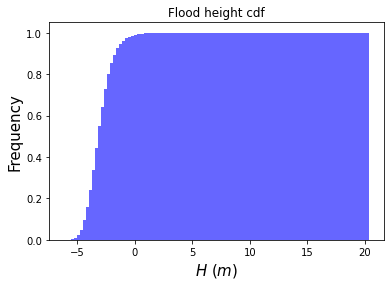

Maximum height :  20.331205431729757
95th quantile :  -1.0486188577639113
99th quantile :  0.20943961773997702


In [49]:
plt.figure()
plt.hist(S, bins = binsize, facecolor='b', density=True, cumulative=True, alpha=0.6)
plt.title('Flood height cdf')
plt.xlabel(r'$H$ ($m$)',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.show()

print("Maximum height : ",max_H)
print("95th quantile : ",q95)
print("99th quantile : ",q99)